ここではデータ拡張を試す  
resnet18を使う。また全体のデータセットを使って精度を落として、比較しやすいように

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, TensorDataset, Dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from tqdm.auto import tqdm


#import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


# Resnet データローダ

In [2]:
class BasicBlock1d(nn.Module):
    expansion = 1

    def __init__(
            self, 
            in_planes, 
            planes, 
            
            stride=1,
            dropout=0.0):
        
        super(BasicBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu1 = nn.ReLU(True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.relu2 = nn.ReLU(True)
        

        self.downsample = None
        # 以下はスキップ接続のための入力xのリサンプリング
        if stride != 1 or in_planes != self.expansion*planes:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        skipX = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)# ここでreluまで通す
        out = self.conv2(out)
        out = self.bn2(out)
        if self.dropout is not None:
            out = self.dropout(out)
        if self.downsample is not None:
            skipX = self.downsample(x)
        out += skipX # ここでスキップ接続する。加算
        out = self.relu2(out)
        #out = F.relu(out)
        return out

class ResNet1d(nn.Module):
    def __init__(self, block, num_blocks, dropout=0.0, num_classes=8):
        super(ResNet1d, self).__init__()
        self.in_planes = 64 # resnet18に合わせる
        self.dropout = dropout

        self.conv1 = nn.Conv1d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool1d(3,2,1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # strideを２にするブロックがある場合はstride=2を指定する
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout=self.dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
def ResNet18_1d():
    return ResNet1d(BasicBlock1d, [2, 2, 2, 2])


In [3]:
# X:説明変数 y:目的ラベル
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    X = torch.tensor(X, dtype=torch.float32)
    if y is not None:
        y = torch.tensor(y-1, dtype=torch.long)
        dataset = TensorDataset(X,y)
    else:
        dataset = TensorDataset(X)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def forward_by_batches(model, dataloader):
    Y = []
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x[0].to(device)
            Y.append(model(x))
    model.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y


def evaluate_model(model, X, Y, batch_size=1024):
    dataloader = create_dataloader(X, Y, batch_size=batch_size, shuffle=False)
    Y_pred = forward_by_batches(model, dataloader)
    loss = F.cross_entropy(Y_pred, torch.tensor(Y-1.0, dtype=torch.long).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

データ用意

In [4]:
fold = "../../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz_back80000.npy")
gyr_xyz = np.load(f"{fold}gyr_xyz_back80000.npy")
mag_xyz = np.load(f"{fold}mag_xyz_back80000.npy")
label = np.load(f"{fold}sampled_label_back80000.npy")
xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)
del acc_xyz
del gyr_xyz
del mag_xyz
print(xyz.shape)
print(label.shape)

(79999, 9, 500)
(79999,)


In [5]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = xyz.reshape(-1, xyz.shape[-1])  # (196072*3, 500
scaled_xyz = scaler.fit_transform(xyz_reshaped)  # 標準化
scaled_xyz = scaled_xyz.reshape(xyz.shape)  # 元の形に戻す
print(scaled_xyz.shape)  # (196072, 3, 500)

(79999, 9, 500)


データ数の設定

In [21]:
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]
print(scaled_xyz_random.shape)
print(label_sm_random.shape)

(20000, 9, 500)
(20000,)


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

Train data shape: (16000, 9, 500)
Test data shape: (4000, 9, 500)
Train label shape: (16000,)
Test label shape: (4000,)
5.0    2331
7.0    2264
6.0    2253
2.0    2186
1.0    2172
4.0    2122
8.0    1739
3.0     933
Name: count, dtype: int64
5.0    606
7.0    591
6.0    576
1.0    545
2.0    511
4.0    510
8.0    451
3.0    210
Name: count, dtype: int64


# データ拡張

## アンダーサンプリング

In [33]:
# アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler
#データ数size 
size = 45000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]
# 最初のデータ
print(scaled_xyz_random.shape)
print(pd.Series(label_sm_random).value_counts())

# アンダーサンプリング
rus = RandomUnderSampler()
reshaped = scaled_xyz_random.reshape(scaled_xyz_random.shape[0], -1)
X_reshaped, y_resampled = rus.fit_resample(reshaped, label_sm_random)
X_reshaped = X_reshaped.reshape(-1, 9, 500)

# アンダーサンプリング後のデータ
print(X_reshaped.shape)
print(y_resampled.shape)
print(pd.Series(y_resampled).value_counts())

# データスプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(X_reshaped, y_resampled, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

(45000, 9, 500)
5.0    6856
6.0    6437
7.0    6371
1.0    6099
2.0    5965
4.0    5839
8.0    4867
3.0    2566
Name: count, dtype: int64
(20528, 9, 500)
(20528,)
1.0    2566
2.0    2566
3.0    2566
4.0    2566
5.0    2566
6.0    2566
7.0    2566
8.0    2566
Name: count, dtype: int64
Train data shape: (16422, 9, 500)
Test data shape: (4106, 9, 500)
Train label shape: (16422,)
Test label shape: (4106,)
2.0    2107
5.0    2085
4.0    2069
7.0    2048
1.0    2037
3.0    2032
6.0    2027
8.0    2017
Name: count, dtype: int64
8.0    549
6.0    539
3.0    534
1.0    529
7.0    518
4.0    497
5.0    481
2.0    459
Name: count, dtype: int64


## オーバーサンプリング
単純なオーバーサンプリングやSMOTEなど

In [37]:
# オーバーサンプリング
from imblearn.over_sampling import RandomOverSampler
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]

#スプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)
print("train_xyz shape:", train_xyz.shape)
print("train label shape:", train_label.shape)
print("test_xyz shape:", test_xyz.shape)
print("test label shape:", test_label.shape)
print(pd.Series(train_label).value_counts())

reshaped = train_xyz.reshape(train_xyz.shape[0], -1)
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(reshaped, train_label)
X_resampled = X_resampled.reshape(-1, 9, 500)
print("X_resampled shape:",X_resampled.shape)
print("y_resampled shape:",y_resampled.shape)
print(pd.Series(y_resampled).value_counts())
train_xyz = X_resampled
train_label = y_resampled

train_xyz shape: (16000, 9, 500)
train label shape: (16000,)
test_xyz shape: (4000, 9, 500)
test label shape: (4000,)
5.0    2432
7.0    2328
6.0    2265
2.0    2155
1.0    2110
4.0    2067
8.0    1747
3.0     896
Name: count, dtype: int64
X_resampled shape: (19456, 9, 500)
y_resampled shape: (19456,)
5.0    2432
4.0    2432
1.0    2432
8.0    2432
7.0    2432
2.0    2432
6.0    2432
3.0    2432
Name: count, dtype: int64


### SMOTE

In [41]:
# オーバーサンプリング
from imblearn.over_sampling import SMOTE
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]

#スプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)
print("train_xyz shape:", train_xyz.shape)
print("train label shape:", train_label.shape)
print("test_xyz shape:", test_xyz.shape)
print("test label shape:", test_label.shape)
print(pd.Series(train_label).value_counts())
"""
reshaped = train_xyz.reshape(train_xyz.shape[0], -1)
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(reshaped, train_label)
X_resampled = X_resampled.reshape(-1, 9, 500)
print("X_resampled shape:",X_resampled.shape)
print("y_resampled shape:",y_resampled.shape)
print(pd.Series(y_resampled).value_counts())
train_xyz = X_resampled
train_label = y_resampled"""
reshaped = train_xyz.reshape(train_xyz.shape[0], -1)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(reshaped, train_label)
X_resampled = X_resampled.reshape(-1, 9, 500)
print("X_resampled shape:",X_resampled.shape)
print("y_resampled shape:",y_resampled.shape)
print(pd.Series(y_resampled).value_counts())
train_xyz = X_resampled
train_label = y_resampled


train_xyz shape: (16000, 9, 500)
train label shape: (16000,)
test_xyz shape: (4000, 9, 500)
test label shape: (4000,)
5.0    2377
6.0    2328
7.0    2294
2.0    2202
1.0    2106
4.0    2105
8.0    1663
3.0     925
Name: count, dtype: int64
X_resampled shape: (19016, 9, 500)
y_resampled shape: (19016,)
3.0    2377
5.0    2377
1.0    2377
2.0    2377
8.0    2377
6.0    2377
7.0    2377
4.0    2377
Name: count, dtype: int64


### 

### ADASYN

In [47]:
# オーバーサンプリング
from imblearn.over_sampling import ADASYN
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]

#スプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)
print("train_xyz shape:", train_xyz.shape)
print("train label shape:", train_label.shape)
print("test_xyz shape:", test_xyz.shape)
print("test label shape:", test_label.shape)
print(pd.Series(train_label).value_counts())

reshaped = train_xyz.reshape(train_xyz.shape[0], -1)
sampling = ADASYN(sampling_strategy="minority")
X_resampled, y_resampled = sampling.fit_resample(reshaped, train_label)
X_resampled = X_resampled.reshape(-1, 9, 500)
print("X_resampled shape:",X_resampled.shape)
print("y_resampled shape:",y_resampled.shape)
print(pd.Series(y_resampled).value_counts())
train_xyz = X_resampled
train_label = y_resampled


train_xyz shape: (16000, 9, 500)
train label shape: (16000,)
test_xyz shape: (4000, 9, 500)
test label shape: (4000,)
5.0    2369
7.0    2263
2.0    2218
6.0    2210
1.0    2181
4.0    2092
8.0    1765
3.0     902
Name: count, dtype: int64
X_resampled shape: (17694, 9, 500)
y_resampled shape: (17694,)
3.0    2596
5.0    2369
7.0    2263
2.0    2218
6.0    2210
1.0    2181
4.0    2092
8.0    1765
Name: count, dtype: int64


### Borderline-SMOTE  

In [54]:
# オーバーサンプリング
from imblearn.over_sampling import BorderlineSMOTE
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]

#スプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)
print("train_xyz shape:", train_xyz.shape)
print("train label shape:", train_label.shape)
print("test_xyz shape:", test_xyz.shape)
print("test label shape:", test_label.shape)
print(pd.Series(train_label).value_counts())

reshaped = train_xyz.reshape(train_xyz.shape[0], -1)
sampling = BorderlineSMOTE()
X_resampled, y_resampled = sampling.fit_resample(reshaped, train_label)
X_resampled = X_resampled.reshape(-1, 9, 500)
print("X_resampled shape:",X_resampled.shape)
print("y_resampled shape:",y_resampled.shape)
print(pd.Series(y_resampled).value_counts())
train_xyz = X_resampled
train_label = y_resampled


train_xyz shape: (16000, 9, 500)
train label shape: (16000,)
test_xyz shape: (4000, 9, 500)
test label shape: (4000,)
5.0    2409
6.0    2272
7.0    2206
1.0    2177
2.0    2155
4.0    2093
8.0    1741
3.0     947
Name: count, dtype: int64
X_resampled shape: (19272, 9, 500)
y_resampled shape: (19272,)
6.0    2409
5.0    2409
1.0    2409
3.0    2409
7.0    2409
2.0    2409
8.0    2409
4.0    2409
Name: count, dtype: int64


### KMeans-SMOTE

In [59]:
# オーバーサンプリング
from imblearn.over_sampling import KMeansSMOTE
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]

#スプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)
print("train_xyz shape:", train_xyz.shape)
print("train label shape:", train_label.shape)
print("test_xyz shape:", test_xyz.shape)
print("test label shape:", test_label.shape)
print(pd.Series(train_label).value_counts())

reshaped = train_xyz.reshape(train_xyz.shape[0], -1)
sampling = KMeansSMOTE(cluster_balance_threshold=0.01)
X_resampled, y_resampled = sampling.fit_resample(reshaped, train_label)
X_resampled = X_resampled.reshape(-1, 9, 500)
print("X_resampled shape:",X_resampled.shape)
print("y_resampled shape:",y_resampled.shape)
print(pd.Series(y_resampled).value_counts())
train_xyz = X_resampled
train_label = y_resampled


train_xyz shape: (16000, 9, 500)
train label shape: (16000,)
test_xyz shape: (4000, 9, 500)
test label shape: (4000,)
5.0    2428
7.0    2287
6.0    2277
1.0    2220
2.0    2128
4.0    2076
8.0    1696
3.0     888
Name: count, dtype: int64


c:\Users\kaiha\anaconda3\envs\labo_Okita02\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\kaiha\anaconda3\envs\labo_Okita02\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\kaiha\anaconda3\envs\labo_Okita02\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environme

X_resampled shape: (19466, 9, 500)
y_resampled shape: (19466,)
1.0    2435
2.0    2435
6.0    2434
4.0    2434
7.0    2434
8.0    2433
3.0    2433
5.0    2428
Name: count, dtype: int64


すべてのオーバーサンプリング手法を適用して大きなデータセットを作成する

In [ ]:
#データ数size 
size = 20000
total_data = scaled_xyz.shape[0]
random_indices = np.random.choice(total_data, size, replace=False, )
scaled_xyz_random = scaled_xyz[random_indices, :, :]
label_sm_random = label[random_indices]
#スプリット
# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz_random, label_sm_random, test_size=0.2,random_state=40)
print("train_xyz shape:", train_xyz.shape)
print("train label shape:", train_label.shape)
print("test_xyz shape:", test_xyz.shape)
print("test label shape:", test_label.shape)
print(pd.Series(train_label).value_counts())

# 学習

In [60]:
lr = 1e-4
resnet = ResNet1d(BasicBlock1d, [2,2,2,2], dropout=0).to(device)#resnet18
#print(resnet)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr, weight_decay=1e-4, amsgrad=True)

In [61]:
from torch.cuda.amp import autocast, GradScaler

# Mixed Precision Trainingの設定 メモリ削減fp16して高速化できるらしいから使ってみる
scaler = GradScaler()

# トレーニングループ
num_epoch = 100
batch_size = 64  # バッチサイズを調整
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
count = 0
# 早期終了の設定
early_stopping_patience = 7  # 早期終了のためのエポック数
best_loss = float('inf')
epochs_no_improve = 0

for i in tqdm(range(num_epoch)):
    if False:#i!=0:
        if loss.item() < 0.4 and count == 0 and i > 19:
            batch_size = 2048
            count += 1
            print(f"batch_size:{batch_size}, count:{count}")
        elif count != 0:
            count += 1
            if count == 10:
                batch_size *= 2
                print(f"batch_size:{batch_size}, count:{count}")
            if count == 9:
                print("break!")
                break
    resnet.train()
    dataloader = create_dataloader(train_xyz, train_label, batch_size=batch_size, shuffle=True)
    
    epoch_losses = []

    for x, target in dataloader:
        x, target = x.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        
        with autocast(dtype=torch.float16): # ここでfp16で計算することができる（松石さんの資料を参考に）
            output = resnet(x)
            loss = loss_fn(output, target)
        #逆伝播
        scaler.scale(loss).backward()

        # クリップ時に正しくできるように一度スケールを戻す
        scaler.unscale_(optimizer)
        
        # 勾配のクリッピング　大きすぎる勾配をクリップ
        nn.utils.clip_grad_norm_(resnet.parameters(), max_norm=1.0)
        
        # パラメータの更新
        scaler.step(optimizer)
        # スケールの更新
        scaler.update()
        
        # Logging -- track train loss
        #losses.append(loss.item())
        epoch_losses.append(loss.item())

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    # Logging -- average train loss in this epoch
    avg_epoch_loss = np.mean(epoch_losses)
    loss_history_train.append(avg_epoch_loss)
    #loss_history_train.append(np.mean(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(resnet, test_xyz, test_label)
    test_loss = results["loss"]
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
    print(f"Epoch {i+1}/{num_epoch}, Loss: {avg_epoch_loss}, test Loss:{test_loss}, Kappa: {results['kappa']}")
    # 早期終了のチェック
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping at epoch {i+1}")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 1.1371115078691576, test Loss:1.0263863801956177, Kappa: 0.5827125198123358
Epoch 2/100, Loss: 0.8371781487933925, test Loss:0.8266088366508484, Kappa: 0.6478287721587606
Epoch 3/100, Loss: 0.7364236182853824, test Loss:0.7890231609344482, Kappa: 0.67010929466342
Epoch 4/100, Loss: 0.6821579536453622, test Loss:0.754051923751831, Kappa: 0.6971390072219537
Epoch 5/100, Loss: 0.6499159412305863, test Loss:0.7184598445892334, Kappa: 0.6963169343756901
Epoch 6/100, Loss: 0.6063255510369285, test Loss:0.6878483891487122, Kappa: 0.7029569825673059
Epoch 7/100, Loss: 0.5818371306677333, test Loss:0.6652852892875671, Kappa: 0.7161278571659128
Epoch 8/100, Loss: 0.5574925576077133, test Loss:0.6266440153121948, Kappa: 0.7446463640351408
Epoch 9/100, Loss: 0.5382178349573105, test Loss:0.6500829458236694, Kappa: 0.7366255238795377
Epoch 10/100, Loss: 0.523152884596684, test Loss:0.5913145542144775, Kappa: 0.7552736547986625
Epoch 11/100, Loss: 0.5057490826630201, test Loss:0.5

# 評価  
ここではv18などとは異なるデータ用意をしている。  
なので性能は出ないはず。  
今回はデータ拡張をして、どれだけ性能向上に寄与するのかをみる。  
  
*前回のままの方法だとデータ拡張をしないでも精度0.96出ていたので性能比較しにくい。  
全体データからランダムサンプリングして学習させると比較して性能は出にくくなる。

### データ拡張なし　２万データ

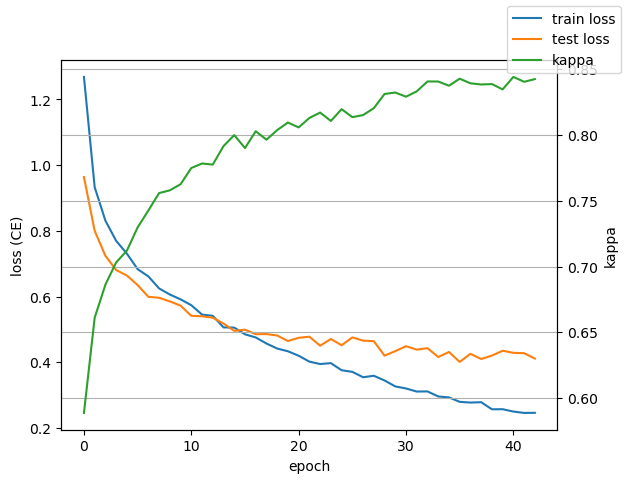


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.82      0.84      0.83       545
         2.0       0.96      0.94      0.95       511
         3.0       1.00      0.98      0.99       210
         4.0       0.98      0.97      0.98       510
         5.0       0.89      0.91      0.90       606
         6.0       0.85      0.85      0.85       576
         7.0       0.77      0.75      0.76       591
         8.0       0.71      0.71      0.71       451

    accuracy                           0.86      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.86      0.86      0.86      4000



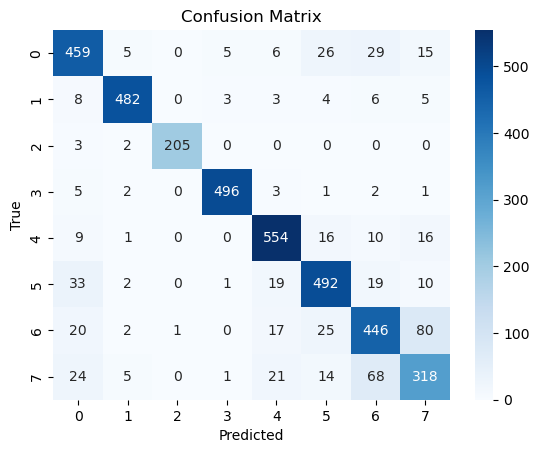

In [28]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## アンダーサンプリング

### アンダーサンプリング　２万データ(実際は8700くらいまでデータ減少)

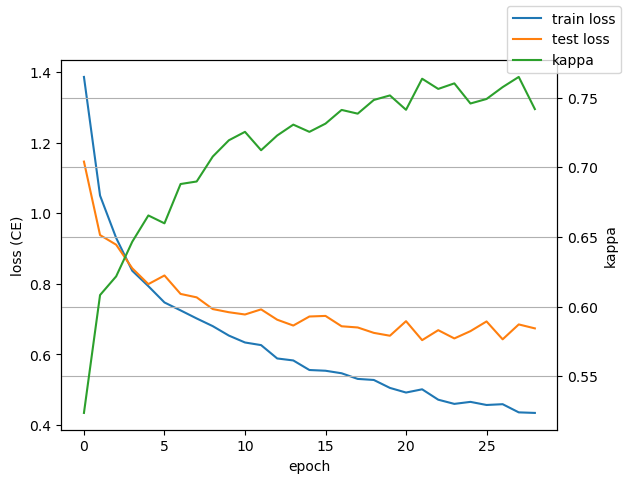


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.63      0.80      0.70       206
         2.0       0.90      0.91      0.91       209
         3.0       0.99      0.98      0.98       204
         4.0       0.93      0.94      0.93       204
         5.0       0.76      0.82      0.79       241
         6.0       0.73      0.70      0.71       236
         7.0       0.60      0.58      0.59       226
         8.0       0.69      0.51      0.59       214

    accuracy                           0.77      1740
   macro avg       0.78      0.78      0.78      1740
weighted avg       0.77      0.77      0.77      1740



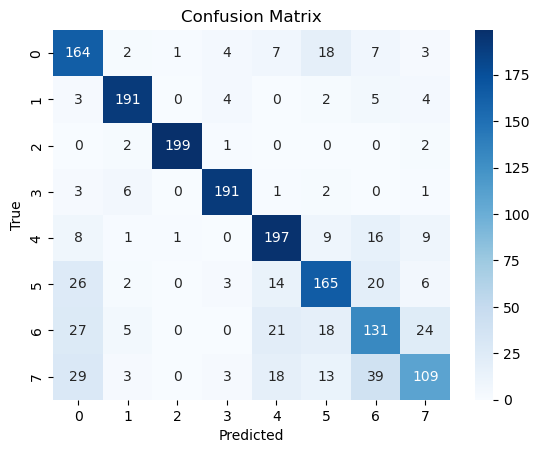

In [32]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### アンダーサンプリング　45000データ(アンダーサンプリングによって約２万データ)  
アンダーサンプリングなしのものと同じくらいの大きさの訓練データとテストデータになる。

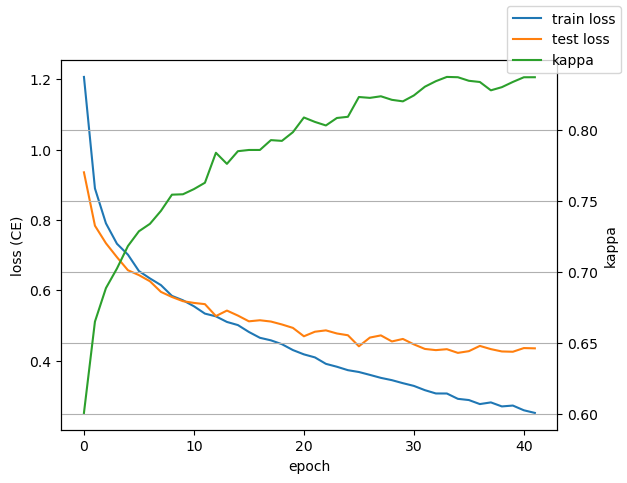


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.77      0.83      0.80       529
         2.0       0.91      0.96      0.93       459
         3.0       1.00      1.00      1.00       534
         4.0       0.98      0.97      0.97       497
         5.0       0.84      0.92      0.88       481
         6.0       0.86      0.80      0.83       539
         7.0       0.80      0.63      0.70       518
         8.0       0.73      0.78      0.75       549

    accuracy                           0.86      4106
   macro avg       0.86      0.86      0.86      4106
weighted avg       0.86      0.86      0.86      4106



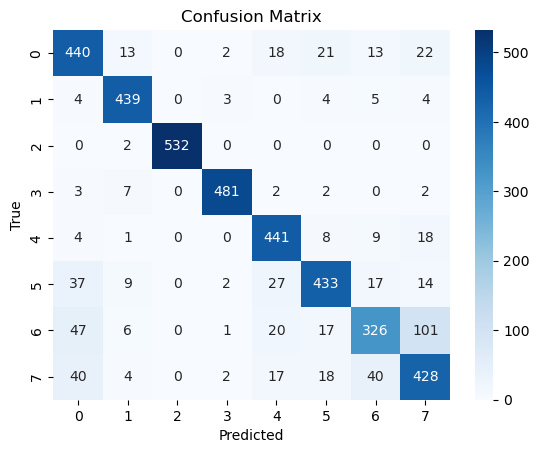

In [36]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## オーバーサンプリング

### 2万データランダムオーバーサンプリング  
実際の訓練データ数は16000 -> 19768に

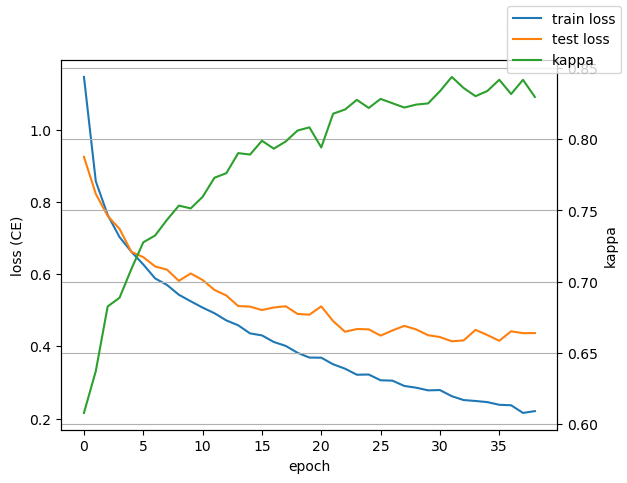


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.79      0.86      0.82       578
         2.0       0.93      0.94      0.93       508
         3.0       1.00      1.00      1.00       226
         4.0       0.96      0.96      0.96       547
         5.0       0.89      0.86      0.87       576
         6.0       0.83      0.87      0.85       615
         7.0       0.74      0.69      0.71       510
         8.0       0.74      0.70      0.72       440

    accuracy                           0.85      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.85      0.85      0.85      4000



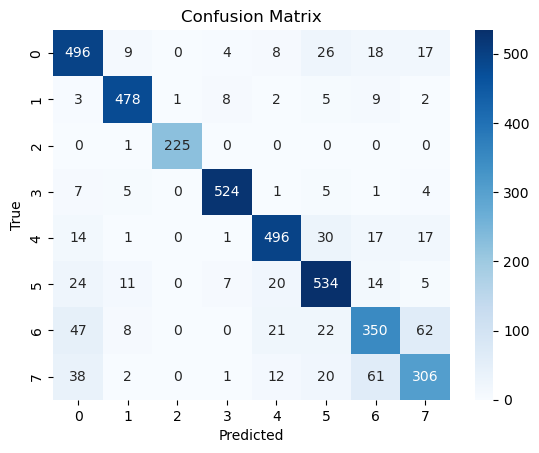

In [40]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### ２万データオーバーサンプリング　SMOTE

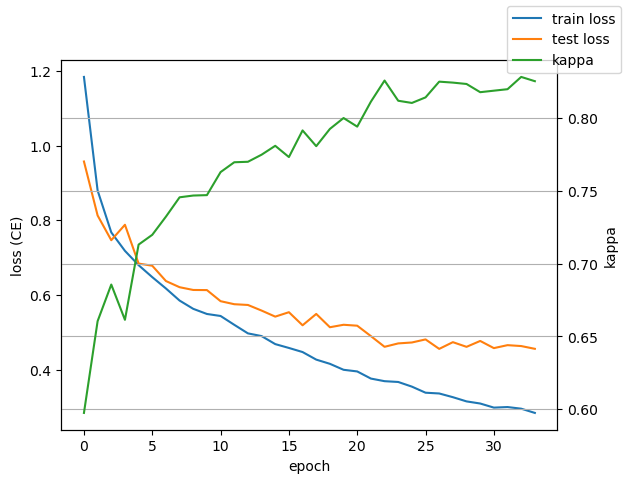


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.80      0.81      0.80       522
         2.0       0.97      0.94      0.96       583
         3.0       0.99      0.99      0.99       216
         4.0       0.97      0.96      0.97       510
         5.0       0.86      0.87      0.87       563
         6.0       0.80      0.81      0.80       582
         7.0       0.76      0.75      0.76       590
         8.0       0.72      0.71      0.72       434

    accuracy                           0.85      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.85      0.85      0.85      4000



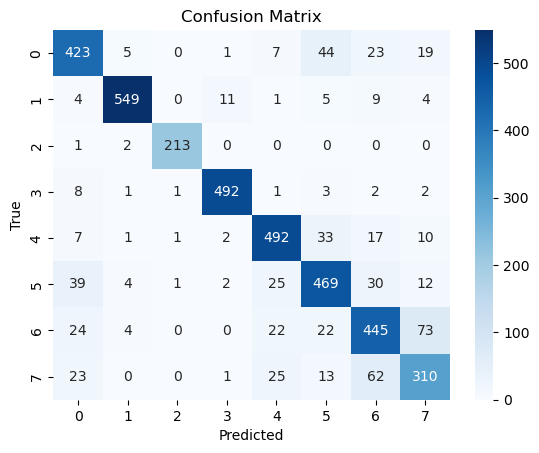

In [44]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### ADASYN オーバーサンプリング

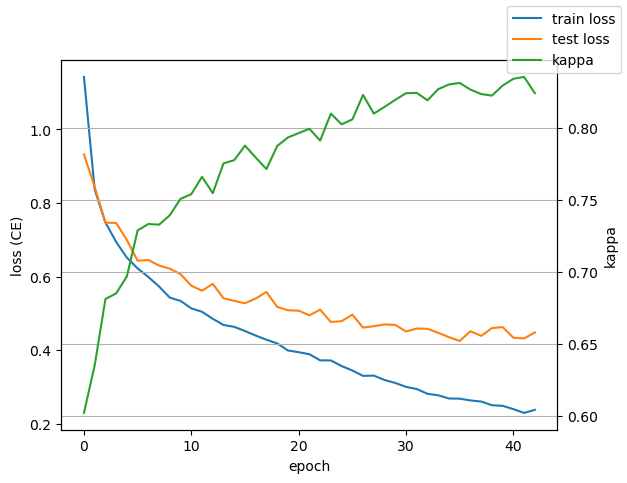


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.78      0.83      0.80       500
         2.0       0.96      0.93      0.94       530
         3.0       0.98      0.99      0.99       200
         4.0       0.96      0.98      0.97       511
         5.0       0.90      0.89      0.89       622
         6.0       0.80      0.85      0.82       617
         7.0       0.74      0.75      0.75       576
         8.0       0.72      0.64      0.68       444

    accuracy                           0.85      4000
   macro avg       0.86      0.86      0.85      4000
weighted avg       0.85      0.85      0.85      4000



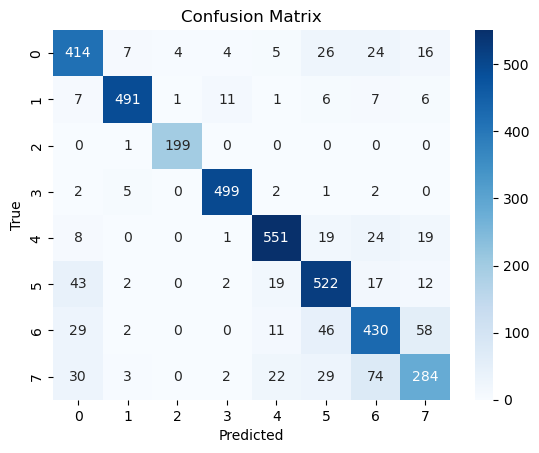

In [53]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Borderline-SMOTE

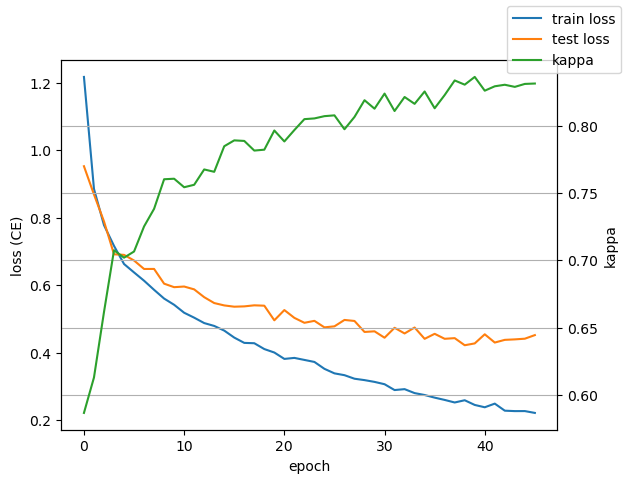


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.79      0.81      0.80       488
         2.0       0.96      0.95      0.96       546
         3.0       1.00      0.98      0.99       221
         4.0       0.95      0.99      0.97       521
         5.0       0.89      0.92      0.90       609
         6.0       0.82      0.84      0.83       587
         7.0       0.75      0.71      0.73       594
         8.0       0.71      0.68      0.70       434

    accuracy                           0.85      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.85      0.85      0.85      4000



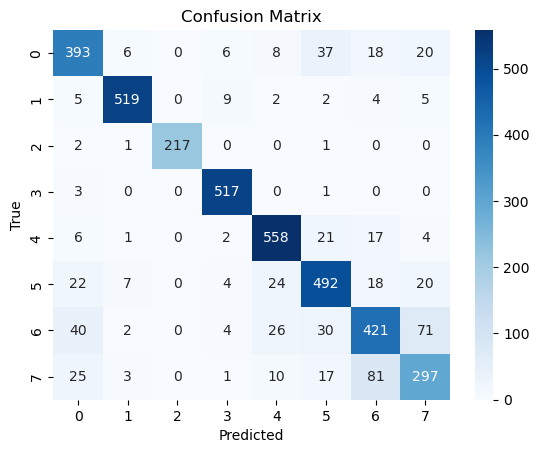

In [57]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### KMeans-SMOTE

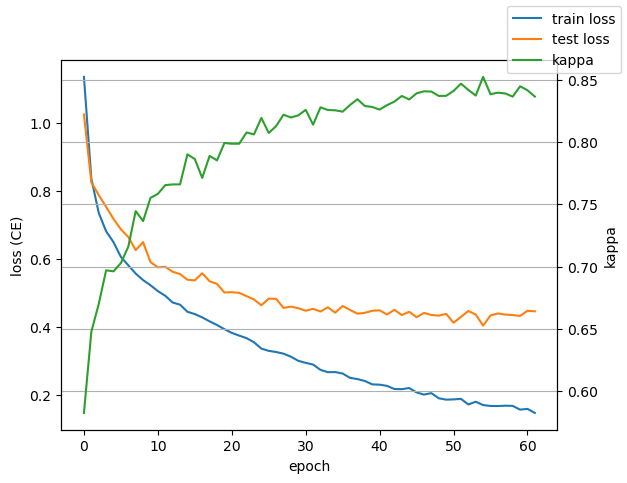


Classifier performance
Out of sample:

              precision    recall  f1-score   support

         1.0       0.79      0.86      0.83       567
         2.0       0.93      0.96      0.95       512
         3.0       1.00      0.99      0.99       222
         4.0       0.97      0.96      0.96       539
         5.0       0.90      0.86      0.88       582
         6.0       0.86      0.82      0.84       589
         7.0       0.76      0.75      0.75       540
         8.0       0.71      0.72      0.72       449

    accuracy                           0.86      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.86      0.86      0.86      4000



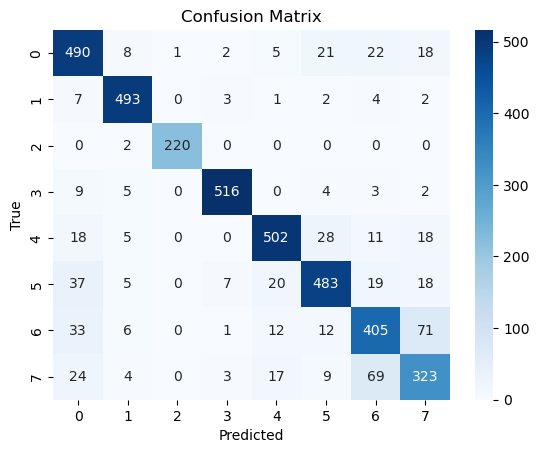

In [62]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
plt.show()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
report = classification_report(test_label, results["Y_pred"])
print('Out of sample:\n')
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, results["Y_pred"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()